### Quantum error correction.

In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import math

backend = AerSimulator()

#### test the expected output

In [2]:
theta = math.pi / 3
qc_test = QuantumCircuit(1, 1)
qc_test.rx(theta, 0)
qc_test.measure(0, 0)
job = backend.run(transpile(qc_test, backend), shots=1024)
measure = job.result().get_counts() 
print(measure)

{'0': 756, '1': 268}


#### protect quantum information from bit-flip

Alice tried to send her qubit $ a|0\rangle + b|1\rangle $ to Bob and sent $ a|000\rangle + b|111\rangle $

In [3]:
def correct_1(info_phase, bit_flip):
    # from Alice
    qc = QuantumCircuit(5, 1)
    qc.rx(info_phase, 0)
    qc.cx(0, 1)
    qc.cx(0, 2)
    qc.barrier()
    # in transit
    if not len(bit_flip)==0:
        for bit in bit_flip:
            qc.x(bit)
        qc.barrier()
    # Bob receives
    qc.cx(0, 4)
    qc.cx(1, 4)
    qc.cx(1, 3)
    qc.cx(2, 3)
    qc.cx(3, 4)
    qc.x(3)
    qc.ccx(4, 3, 0)
    qc.x(3)
    qc.x(4)
    qc.ccx(4, 3, 1)
    qc.x(4)
    qc.ccx(4, 3, 2)
    qc.cx(0, 2)
    qc.cx(0, 1)
    qc.barrier()
    qc.measure([0], [0])
    return qc


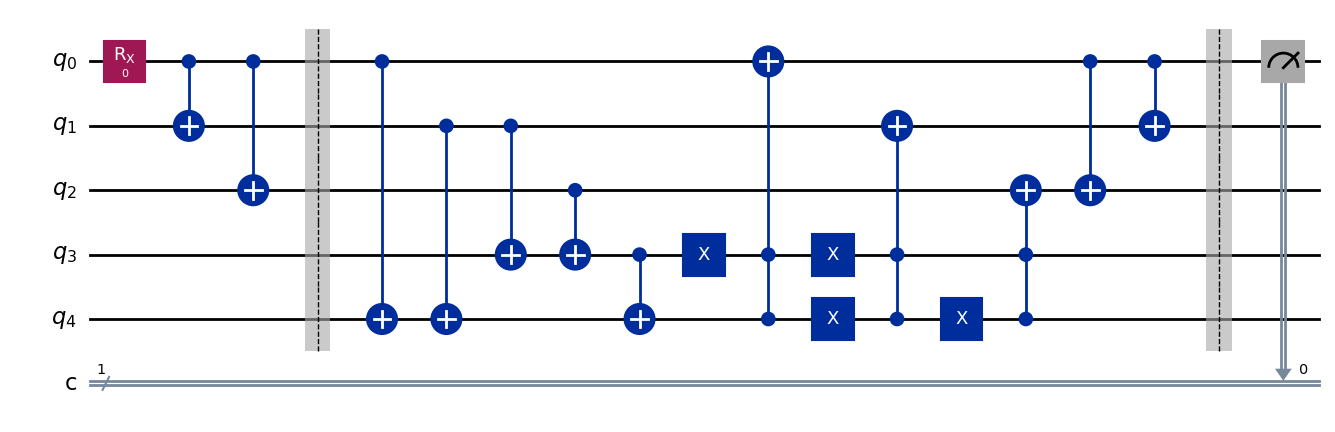

In [4]:
qc_show_1 = correct_1(0, [])
qc_show_1.draw(output='mpl')

In [5]:
bit_flips = [[], [0], [1], [2], [0,1], [0,2], [1,2],[0,1,2]]
theta = math.pi / 3
for bit_flip in bit_flips:
    qc = correct_1(theta, bit_flip)
    job = backend.run(transpile(qc, backend), shots=1024)
    measure = job.result().get_counts()
    print("theta: ", theta, "bit_flip: ", bit_flip, "measure: ", measure)


theta:  1.0471975511965976 bit_flip:  [] measure:  {'0': 759, '1': 265}
theta:  1.0471975511965976 bit_flip:  [0] measure:  {'0': 773, '1': 251}
theta:  1.0471975511965976 bit_flip:  [1] measure:  {'0': 771, '1': 253}
theta:  1.0471975511965976 bit_flip:  [2] measure:  {'0': 788, '1': 236}
theta:  1.0471975511965976 bit_flip:  [0, 1] measure:  {'0': 263, '1': 761}
theta:  1.0471975511965976 bit_flip:  [0, 2] measure:  {'1': 778, '0': 246}
theta:  1.0471975511965976 bit_flip:  [1, 2] measure:  {'1': 784, '0': 240}
theta:  1.0471975511965976 bit_flip:  [0, 1, 2] measure:  {'0': 256, '1': 768}


#### protect quantum information from phase-flip errors

Alice tried to send her qubit $ a|0\rangle + b|1\rangle $ to Bob and sent $ H(a|000\rangle + b|111\rangle) $

In [6]:
def correct_2(info_phase, phase_flip):
    # from Alice
    qc = QuantumCircuit(5, 1)
    qc.rx(info_phase, 0)
    qc.cx(0, 1)
    qc.cx(0, 2)
    qc.h([0, 1, 2])
    qc.barrier()
    # in transit
    if not len(phase_flip)==0:
        for bit in phase_flip:
            qc.z(bit)
        qc.barrier()
    # Bob receives
    qc.h([0, 1, 2])
    qc.cx(0, 4)
    qc.cx(1, 4)
    qc.cx(1, 3)
    qc.cx(2, 3)
    qc.cx(3, 4)
    qc.x(3)
    qc.ccx(4, 3, 0)
    qc.x(3)
    qc.x(4)
    qc.ccx(4, 3, 1)
    qc.x(4)
    qc.ccx(4, 3, 2)
    qc.cx(0, 2)
    qc.cx(0, 1)
    qc.barrier()
    qc.measure([0], [0])
    return qc

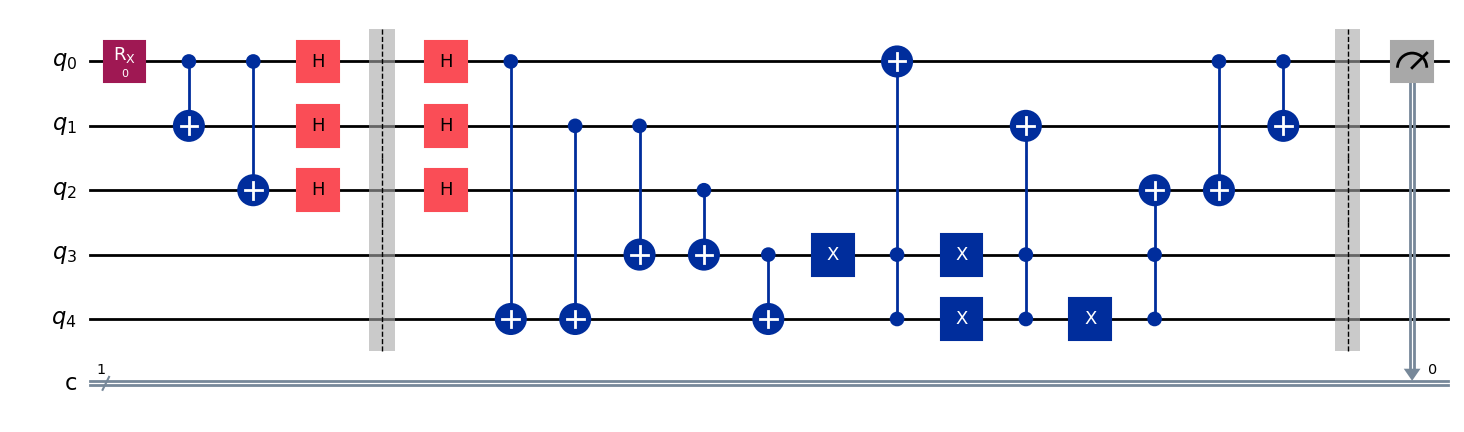

In [7]:
qc_show_2 = correct_2(0, [])
qc_show_2.draw(output='mpl')

In [8]:
phase_flips = [[], [0], [1], [2], [0,1], [0,2], [1,2], [0,1,2]]
for phase_flip in phase_flips:
    qc = correct_2(theta, phase_flip)
    job = backend.run(transpile(qc, backend), shots=1024)
    measure = job.result().get_counts()
    print("theta: ", theta, "phase_flip: ", phase_flip, "measure: ", measure)

theta:  1.0471975511965976 phase_flip:  [] measure:  {'0': 788, '1': 236}
theta:  1.0471975511965976 phase_flip:  [0] measure:  {'0': 763, '1': 261}
theta:  1.0471975511965976 phase_flip:  [1] measure:  {'0': 763, '1': 261}
theta:  1.0471975511965976 phase_flip:  [2] measure:  {'1': 270, '0': 754}
theta:  1.0471975511965976 phase_flip:  [0, 1] measure:  {'1': 767, '0': 257}
theta:  1.0471975511965976 phase_flip:  [0, 2] measure:  {'1': 777, '0': 247}
theta:  1.0471975511965976 phase_flip:  [1, 2] measure:  {'1': 743, '0': 281}
theta:  1.0471975511965976 phase_flip:  [0, 1, 2] measure:  {'1': 760, '0': 264}


#### Protect quantum information from both bit flips and phase flips simultaneously.

This known as Shor's 9 qubit code. It protect against up to both bit flips and phase flips on any qubit.

However, if more than 1 qubit flips, the code will fail.

Reference: https://quantumcomputinguk.org/tutorials/quantum-error-correction-shor-code-in-qiskit

In [9]:
def shor_9(info_phase, flip_qubit, flip_type):
    # from Alice
    qc = QuantumCircuit(9, 1)
    qc.rx(info_phase, 0)
    qc.cx(0, 3)
    qc.cx(0, 6)
    qc.h([0, 3, 6])
    for i in range(3): 
        qc.cx(i*3, 3*i+1)
        qc.cx(i*3, 3*i+2)
    qc.barrier()
    # in transit
    if flip_type[0]=='1':
        qc.x(flip_qubit)
    if flip_type[1]=='1':
        qc.z(flip_qubit)
    if not flip_type == '00':
        qc.barrier()
    # Bob receives
    for i in range(3): 
        qc.cx(i*3, 3*i+1)
        qc.cx(i*3, 3*i+2)
        qc.ccx(i*3+1, i*3+2, i*3)
        qc.h(i*3)
    qc.cx(0, 3)
    qc.cx(0, 6)
    qc.ccx(3, 6, 0)
    qc.measure(0, 0)
    return qc

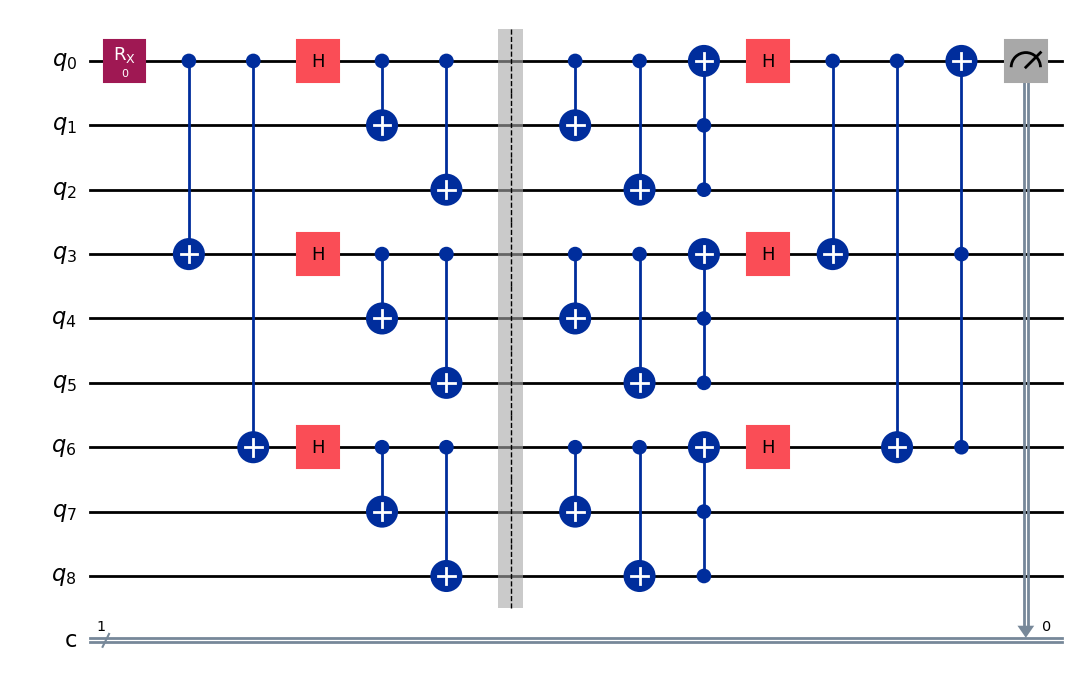

In [10]:
qc_show_3 = shor_9(0, 0, '00')
qc_show_3.draw(output='mpl')

In [11]:
flip_qubits = list(range(9))
flip_types = ['00', '01', '10', '11']
theta = math.pi / 3
for flip_qubit in flip_qubits:
    for flip_type in flip_types:
        qc = shor_9(theta, flip_qubit, flip_type)
        job = backend.run(transpile(qc, backend), shots=1024)
        measure = job.result().get_counts()
        print("theta: ", theta, "flip qubit and type: ", flip_qubit, flip_type, "measure: ", measure)
        

theta:  1.0471975511965976 flip qubit and type:  0 00 measure:  {'1': 249, '0': 775}
theta:  1.0471975511965976 flip qubit and type:  0 01 measure:  {'0': 795, '1': 229}
theta:  1.0471975511965976 flip qubit and type:  0 10 measure:  {'0': 765, '1': 259}
theta:  1.0471975511965976 flip qubit and type:  0 11 measure:  {'1': 253, '0': 771}
theta:  1.0471975511965976 flip qubit and type:  1 00 measure:  {'0': 789, '1': 235}
theta:  1.0471975511965976 flip qubit and type:  1 01 measure:  {'0': 763, '1': 261}
theta:  1.0471975511965976 flip qubit and type:  1 10 measure:  {'0': 777, '1': 247}
theta:  1.0471975511965976 flip qubit and type:  1 11 measure:  {'0': 753, '1': 271}
theta:  1.0471975511965976 flip qubit and type:  2 00 measure:  {'0': 757, '1': 267}
theta:  1.0471975511965976 flip qubit and type:  2 01 measure:  {'0': 766, '1': 258}
theta:  1.0471975511965976 flip qubit and type:  2 10 measure:  {'0': 775, '1': 249}
theta:  1.0471975511965976 flip qubit and type:  2 11 measure:  {